## Imports

In [ ]:
import os
import sys
from pathlib import Path
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from PIL import Image

repo_dir = Path().resolve().parent
sys.path.append(str(repo_dir))
from pkg import models

%load_ext autoreload
%autoreload 2

## Dataset to finetune the model

In [ ]:
from sklearn.model_selection import train_test_split

from pkg.dataset import MeGlassDataset
from scripts.download_dataset import download_meglass

data_dir = repo_dir / 'data'
dataset_dir, labels_fp = download_meglass(data_dir)
dataset = MeGlassDataset(dataset_dir, labels_fp)

dataset_len = len(dataset)

train_idx = range(dataset_len)
# Воспроизводим такие же индексы как в скрипте train.py 
# (не очень чисто но время уже поджимает)
train_idx, test_idx = train_test_split(train_idx, test_size=0.01, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)

test_dataset = MeGlassDataset(dataset_dir, labels_fp, idx=test_idx, is_train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True)

In [8]:
# Примеры фото из датасета
max_i = 0

for i, batch in enumerate(test_loader):

    if i == max_i:
        break

    im = batch['image'][0]
    im = np.array(im)
    im = im.transpose(1, 2, 0)
    plt.imshow(im)
    plt.axis('off')
    plt.show()

## Train

In [4]:
%tensorboard --logdir .

UsageError: Line magic function `%tensorboard` not found.


In [4]:
from scripts.train import train

train(
    dataset_dir,
    labels_fp,
)

Train size: 47437
Val size: 240
Test size: 240


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/natitov/workflow/Laboratory_andrew/temp/hse-ml-nis/venv/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                         | Params
------------------------------------------------------
0 | body | ResNetForImageClassification | 11.2 M
1 | loss | BCELoss                      | 0     
------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.708    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/natitov/workflow/Laboratory_andrew/temp/hse-ml-nis/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Predict

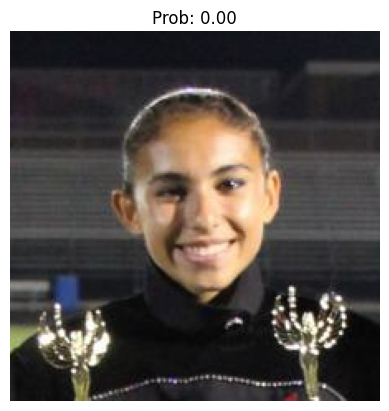

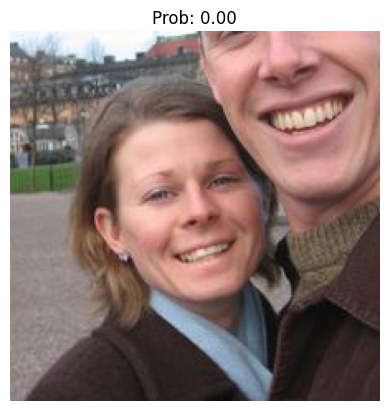

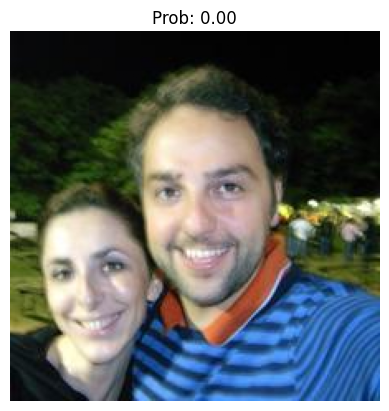

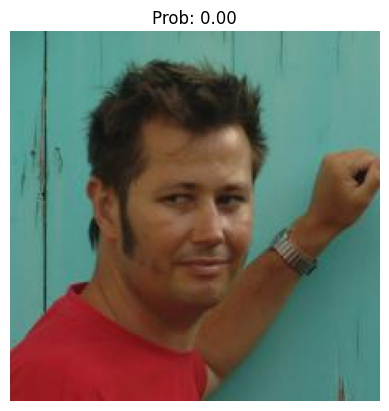

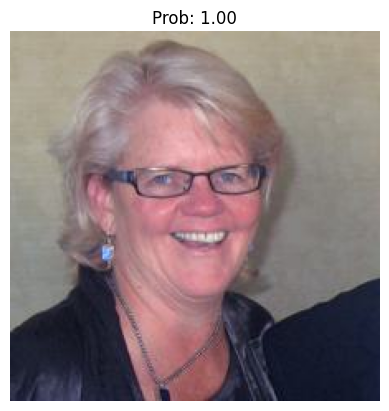

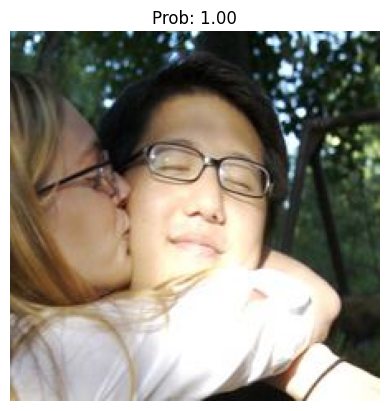

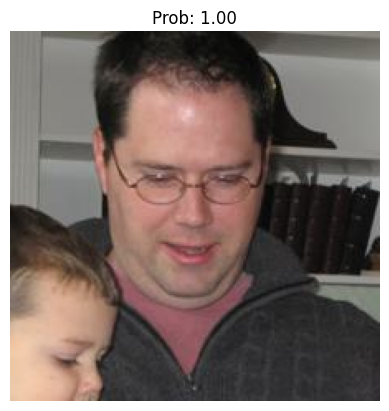

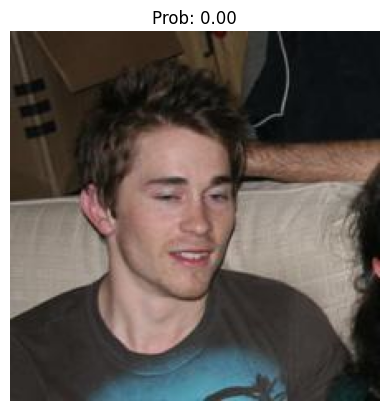

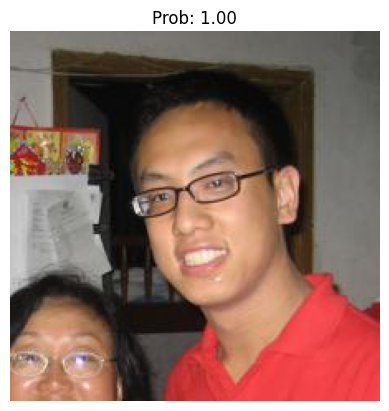

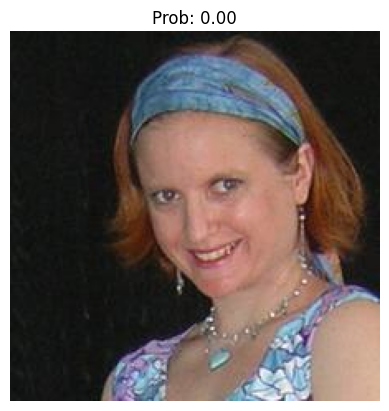

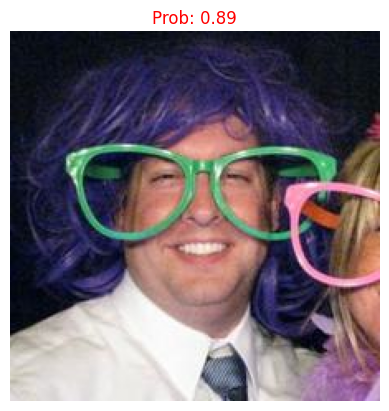

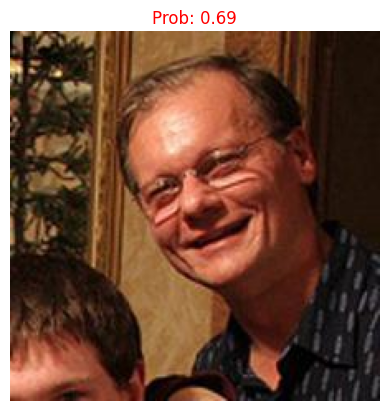

In [41]:
from pkg.models import GlassProbaPredictorTrained

def timed_predict(model, image):
    time1 = time.time_ns()
    prob = model.predict_proba(image)
    time2 = time.time_ns()
    
    pred_time = (time2 - time1) / 10 ** 9
    return prob, pred_time


weights_dir = repo_dir / Path('weights')

model = GlassProbaPredictorTrained.load_from_checkpoint(
    weights_dir / "resnet18_finetuned.ckpt",
    hf_model_name='microsoft/resnet-18',
)
model.eval()

num_photos_to_show = 10
preds = []
labels = []
pred_times = []

for i, batch in enumerate(test_loader):

    im = batch['original_image'][0]
    im = np.array(im)
    im = im.transpose(1, 2, 0)

    prob, pred_time = timed_predict(model, batch['image'])
    
    preds.append(prob > 0.5)
    labels.append(batch['label'].item())
    pred_times.append(pred_time)
    
    is_wrong = preds[-1] != labels[-1]
    
    if i < num_photos_to_show or is_wrong:
        
        plt.imshow(im)
        plt.title(f'Prob: {prob:.2f}', color='red' if is_wrong else 'black')
        plt.axis('off')
        plt.show()

In [38]:
acc = (np.array(preds) == np.array(labels)).mean()
print(f'Точность на тестовой выборке: {acc:.2f}')

Точность на тестовой выборке: 0.99


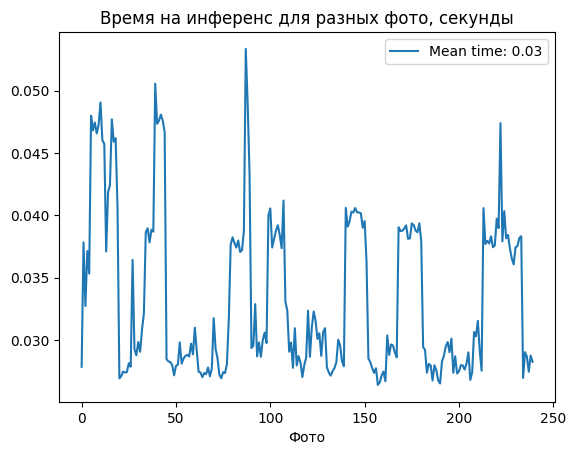

In [19]:
mean_pred_time = np.mean(pred_time)

plt.plot(pred_times, label=f'Mean time: {mean_pred_time:.2f}')
plt.xlabel('Фото')
plt.title('Время на инференс для разных фото, секунды')
plt.legend();